In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import QTable

# Tabla de miembros

In [2]:
members = QTable.read('./../data/raw/members.fit')
members = members.to_pandas()

# Tabla de clusters

In [3]:
clusters = QTable.read('./../data/raw/clusters.fit')
clusters = clusters.to_pandas()
clusters = clusters.sort_values(by='N', ascending=False)

# Tabla de gravedad superficial y radio de cada miembro

Estos dos datos se recuperaron del archivo de Gaia de la tabla `gaiadr3.astrophysical_parameters`.

In [4]:
logg_R_members = QTable.read('./../data/raw/logg_R_members.fits')
logg_R_members = logg_R_members.to_pandas()

---
La siguiente variable indica el cluster, donde a mayor número, menos número de miembros.

In [318]:
cluster_n = 1

Se procede a filtrar los datos de los miembros del cúmulo con más miembros, esto se hace igual que en el notebook `01-exploracion.ipynb`.

In [319]:
cluster_members = members[members['Name'] == clusters.iloc[cluster_n, 0]]

Se filtrann los datos de $\log{g}$ y radio para cada miembro del cúmulo. 

In [320]:
cluster_logg_R_members = logg_R_members[logg_R_members['Name'] == clusters.iloc[cluster_n, 0]]

Luego se une la tabla `cluster_members` y `logg_R_members`.

In [321]:
cluster_members = pd.merge(cluster_members, cluster_logg_R_members[['GaiaDR3', 
                                                                    'logg_gspphot', 
                                                                    'logg_gspphot_lower', 
                                                                    'logg_gspphot_upper', 
                                                                    'radius_gspphot', 
                                                                    'radius_gspphot_lower', 
                                                                    'radius_gspphot_upper']], 
                           how='left', on='GaiaDR3')

Se filtran los datados que sean NaN para $\log{g}$, como para el radio.

In [322]:
cluster_members_mass = cluster_members[
    (cluster_members['logg_gspphot'].notna()) & 
    cluster_members['radius_gspphot'].notna()]

Ahora, para hallar la masa se tiene en cuenta que: $$g = \frac{GM}{R^2}$$

Tenemos $\log{g}$, por lo tanto $g = 10^{\log{g}}$. Donde hay que tener en cuenta que $[g] = \text{cm}\ \text{s}^{-2}$

Para el cálculo de la masa se expresarán todas las unidades en el sistema internacional.

Se crea una nueva columna que contenga los valores de $g\ [\text{m}\ \text{s}^{-2}]$. 

In [323]:
cluster_members_mass['g'] = cluster_members_mass['logg_gspphot'].apply(lambda x: 10**x/100)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


El radio de las estrellas dados por Gaia tienen unidades de $\text{R}_\odot$, entonces se crea una nueva columna con el radio de la estrella en metros.

In [324]:
R_sun = 6.96e8 # m
cluster_members_mass['R'] = cluster_members_mass['radius_gspphot'] * R_sun

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Por último se procede a calcular la masa de las estrellas usando: $$M = \frac{R^2 g}{G}$$ donde el resultado final se expresa en unidades de masas solares.

In [325]:
G = 6.67430e-11 # m^3 s^-2 kg^-1
M_sun = 1.989e30 # kg
cluster_members_mass['M'] = (cluster_members_mass['R']**2 * cluster_members_mass['g'])/(G * M_sun)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Las masas obtenidas fueron:

In [326]:
cluster_members_mass['M']

0        0.504345
2        0.621158
3        0.493857
4        0.577683
5        0.484872
           ...   
65980    0.443455
65981    0.621201
65983    0.744699
65985    0.603021
65986    0.585515
Name: M, Length: 35009, dtype: float64

# Propagación de error

Se tiene que para ambas medidas, gravedad superficial y radio estelar, los niveles de confianza inferior y superior están en el 16% percentil y el 84% percentil respectivamente, donde la medida central es la mediana, según la tabla `gaiadr3.astrophysical_parameters` de Gaia Archive. Luego las incertidumbres para cada medida se calculan como: $$\Delta^{-} = x_\text{med} - p_{16}, \quad \Delta^{+} = p_{84} - x_\text{med}$$

Ahora, se deben evaluar los valores centrales en las derivadas parciales $\partial f / \partial x_i$. Después, los cambios lineales se definen como: $$\delta f_i^+ = \left(\frac{\partial f}{\partial x_i}\right)\Delta x_i^+, \quad \delta f_i^- = \left(\frac{\partial f}{\partial x_i}\right)(-\Delta x_i^-)$$ 

De esto anterior, para obtener la contribución positiva y negativa de la variable $x_i$ se toma respectivamente: $$C_i^+ = \text{max}(\delta f_i^+, \delta f_i^-, 0), \quad C_i^- = \text{max}(-\delta f_i^+, -\delta f_i^-, 0)$$

Finalmente las incertidumbres serían: $$\Delta f^+ = \sqrt{\sum_i (C_i^+)^2}, \quad \Delta f^- = \sqrt{\sum_i (C_i^-)^2}$$

## Propagación de error en la masa

Para proceder en el análisis de la propagación de error, primero se debe propagar el error en la gravedad superficial ya que esta se da como $\log{g}$.

Se procede a extraer los datos de $\log{g}$ como sus niveles de confianza a una nueva tabla.

In [327]:
logg = pd.DataFrame.copy(cluster_members_mass[['GaiaDR3', 
                                               'logg_gspphot',
                                               'logg_gspphot_lower', 
                                               'logg_gspphot_upper']])

Se calculan las incertidumbres y se agregan a la tabla.

In [328]:
logg['Delta_logg_minus'] = logg.loc[:, 'logg_gspphot'] - logg.loc[:, 'logg_gspphot_lower']
logg['Delta_logg_plus'] = logg.loc[:, 'logg_gspphot_upper'] - logg.loc[:, 'logg_gspphot']

Se hace el cálculo de $g$, tal que: $$g = 10^{\log{g}}$$

In [329]:
logg['g'] = logg.loc[:, 'logg_gspphot'].apply(lambda x: 10**x)

Dado que se debe evaluar los valores centrales en la derivada parcial de $g$, dicha derivada tiene la forma: $$\frac{\mathrm{d}f}{\mathrm{d}x} = 10^x \ln{10}$$ entonces se tiene que:

In [330]:
partial = 10**logg.loc[:, 'logg_gspphot']*np.log(10)

Con lo anterior se procede a calcular $\delta f^+$ y $\delta f^-$.

In [331]:
logg['delta_g_plus'] = partial*logg.loc[:, 'Delta_logg_plus']
logg['delta_g_minus'] = partial*(-logg.loc[:, 'Delta_logg_minus'])

Ahora se quiere encontrar la contribución positiva $C^+$ y negativa $C^-$ de la variable. Como en este caso solo se tiene una variable $\log{g}$, entonces no es encesario hacer la raiz de la suma de las cuadraturas de las variables, en otras palabras, estas contribuciones serían el respectivo error.

Contribución positiva y negativa respectivamente son:

In [332]:
logg['Delta_g_plus'] = logg.loc[:, 'delta_g_plus':'delta_g_minus'].apply(np.max, axis=1)
logg['Delta_g_minus'] = (-logg.loc[:, 'delta_g_plus':'delta_g_minus']).apply(np.max, axis=1)

Luego, como se tiene que las unidades de $g$ están en $\text{cgs}$, se procede a pasarlas a unidades del Sistema Internacional, esto se hace dividiendo los valores de $g$ y sus errores por $100$.

In [333]:
logg[['g', 'Delta_g_plus', 'Delta_g_minus']] = logg.loc[:, ['g', 'Delta_g_plus', 'Delta_g_minus']]/100

Por último, se agregan los valores de los errores de $g$ a la tabla `cluster_members_mass`.

In [334]:
cluster_members_mass = pd.merge(cluster_members_mass, logg[['GaiaDR3', 'Delta_g_plus', 'Delta_g_minus']], how='left', on='GaiaDR3')

Ahora, se calcula la incertidumbre del radio de los miembros en metros.

In [335]:
cluster_members_mass['Delta_R_plus'] = (cluster_members_mass.loc[:, 'radius_gspphot_upper'] - cluster_members_mass.loc[:, 'radius_gspphot']) * R_sun
cluster_members_mass['Delta_R_minus'] = (cluster_members_mass.loc[:, 'radius_gspphot'] - cluster_members_mass.loc[:, 'radius_gspphot_lower']) * R_sun

Ya con los datos de $g$ y $R$ y sus respectivas incertidumbres, se procede a hacer la propagación de error de la masa. Primero se deben calcular los valores centrales en las derivadas parciales, estas derivadas son: $$\frac{\partial M}{\partial R} = \frac{2Rg}{G}, \quad \frac{\partial M}{\partial g} = \frac{R^2}{G}$$

Para realizar esto se extraen los datos necesarios en una tabla diferente:

In [336]:
mass_error_data = pd.DataFrame.copy(cluster_members_mass[['GaiaDR3', 
                                                          'g', 'Delta_g_plus', 'Delta_g_minus', 
                                                          'R', 'Delta_R_plus', 'Delta_R_minus']])

Se calculan los valores centrales en las derivadas parciales.

In [337]:
mass_error_data['dM_dg'] = mass_error_data.loc[:, 'R']**2/G
mass_error_data['dM_dR'] = (2*mass_error_data.loc[:, 'R']*mass_error_data.loc[:, 'g'])/G

Luego se calculan los cambios lineales $\delta f_i^+$, $\delta f_i^-$ y sus contribuciones $C_i^+$, $C_i^-$.

Para $g$ se tiene que sus cambios lineales son:

In [338]:
mass_error_data['dM_g_plus'] = mass_error_data.loc[:, 'dM_dg'] * mass_error_data.loc[:, 'Delta_g_plus']
mass_error_data['dM_g_minus'] = mass_error_data.loc[:, 'dM_dg'] * (-mass_error_data.loc[:, 'Delta_g_minus'])

Y sus contribuciones:

In [339]:
mass_error_data['C_g_plus'] = mass_error_data.loc[:, 'dM_g_plus':'dM_g_minus'].apply(np.max, axis=1)
mass_error_data['C_g_minus'] = (-mass_error_data.loc[:, 'dM_g_plus':'dM_g_minus']).apply(np.max, axis=1)

Para $R$ se tiene:

In [340]:
mass_error_data['dM_R_plus'] = mass_error_data.loc[:, 'dM_dR'] * mass_error_data.loc[:, 'Delta_R_plus']
mass_error_data['dM_R_minus'] = mass_error_data.loc[:, 'dM_dR'] * (-mass_error_data.loc[:, 'Delta_R_minus'])

Y sus contribuciones:

In [341]:
mass_error_data['C_R_plus'] = mass_error_data.loc[:, 'dM_R_plus':'dM_R_minus'].apply(np.max, axis=1)
mass_error_data['C_R_minus'] = (-mass_error_data.loc[:, 'dM_R_plus':'dM_R_minus']).apply(np.max, axis=1)

Por último, las incertidumbres para la masa $\Delta M^+$, $\Delta M^-$ en unidades de masa solares serían:

In [342]:
mass_error_data['Delta_M_plus'] = np.sqrt(mass_error_data.loc[:, 'C_g_plus']**2 + mass_error_data.loc[:, 'C_R_plus']**2)
mass_error_data['Delta_M_minus'] = np.sqrt(mass_error_data.loc[:, 'C_g_minus']**2 + mass_error_data.loc[:, 'C_R_minus']**2)

In [343]:
mass_error_data['Delta_M_plus'] = mass_error_data.loc[:, 'Delta_M_plus']/M_sun
mass_error_data['Delta_M_minus'] = mass_error_data.loc[:, 'Delta_M_minus']/M_sun

Por último, se agregan los datos de las incertidumbres de la masa a la tabla `cluster_members_mass`.

In [344]:
cluster_members_mass = pd.merge(cluster_members_mass, mass_error_data.loc[:, ['GaiaDR3', 'Delta_M_plus', 'Delta_M_minus']],
                                how='left', on='GaiaDR3')

# Diagramas color-magnitud y diagramas color-color

Se grafican los diagramas tanto para las estrellas que tienen masa, como para las que no tienen masa, esto con el objetivo de encontrar las masas faltantes.

Se genera una tabla con las estrellas que no tengan parámetros de gravedad superficial o radio.

In [345]:
cluster_members_no_mass = cluster_members[(cluster_members['logg_gspphot'].isna()) | cluster_members['radius_gspphot'].isna()]

## Diagrama color-magnitud

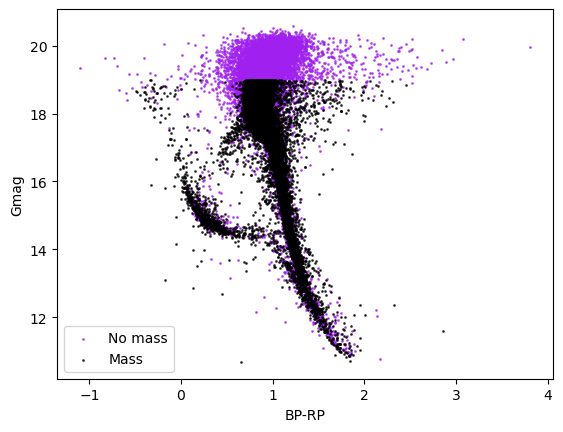

In [346]:
ax_no_mass = cluster_members_no_mass.plot.scatter(
    x='BP-RP',
    y='Gmag',
    s=1,
    c='#A020F0',
    alpha=0.7,
    label='No mass'
)

ax_mass = cluster_members_mass.plot.scatter(
    x='BP-RP', 
    y='Gmag',
    s=1,
    c='000',
    alpha=0.7,
    label='Mass',
    ax=ax_no_mass
)

## Diagramas color-color

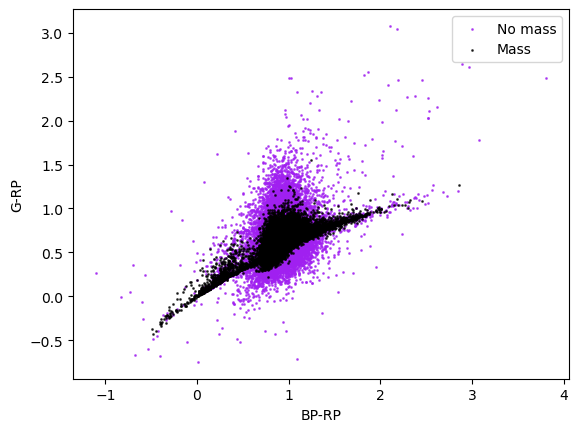

In [347]:
ax_no_mass = cluster_members_no_mass.plot.scatter(
    x='BP-RP',
    y='G-RP',
    s=1,
    c='#A020F0',
    alpha=0.7,
    label='No mass'
)

ax_mass = cluster_members_mass.plot.scatter(
    x='BP-RP', 
    y='G-RP',
    s=1,
    c='000',
    alpha=0.7,
    label='Mass',
    ax=ax_no_mass
)

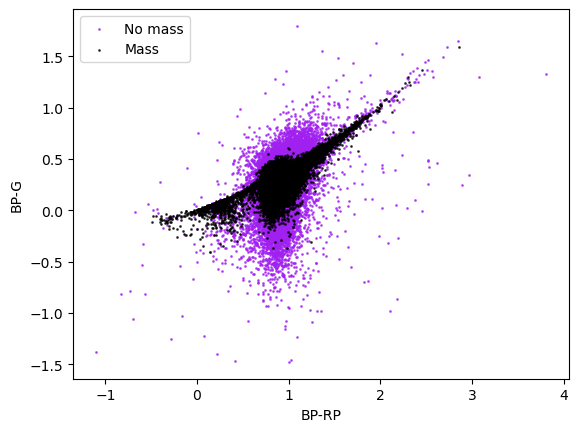

In [348]:
ax_no_mass = cluster_members_no_mass.plot.scatter(
    x='BP-RP',
    y='BP-G',
    s=1,
    c='#A020F0',
    alpha=0.7,
    label='No mass'
)

ax_mass = cluster_members_mass.plot.scatter(
    x='BP-RP', 
    y='BP-G',
    s=1,
    c='000',
    alpha=0.7,
    label='Mass',
    ax=ax_no_mass
)